In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import re
import string
from collections import Counter


import matplotlib.pyplot as plt


import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/meone/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/meone/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/meone/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/meone/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/meone/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /home/meone/nltk_data

In [3]:
df_test=pd.read_csv("SMS_test.xls",encoding='latin1')
df_train=pd.read_csv("SMS_train.xls",encoding="latin1")

In [4]:
df_train.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [6]:
df_train.describe()

,S. No.
count,957.000000
mean,479.000000
std,276.406404
min,1.000000
25%,240.000000
50%,479.000000
75%,718.000000
max,957.000000


In [7]:
df_train.shape

(957, 3)

In [8]:
df_train.isnull().sum()

S. No.          0
Message_body    0
Label           0
dtype: int64

In [9]:
df_train=df_train.drop('S. No.',axis=1)
df_test=df_test.drop('S. No.',axis=1)

In [10]:
df_train.head()

,Message_body,Label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [11]:
df_train.columns = ['text', 'label']
df_test.columns = ['text', 'label']

In [12]:
df_train.head()

,text,label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [13]:
df_train['label']=df_train['label'].replace(['Spam','Non-Spam'],[1,0])
df_test['label']=df_train['label'].replace(['Spam','Non-Spam'],[1,0])

In [14]:
df_train.head()

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1


In [15]:
def clean_text(text):
     # Remove special characters and numbers
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    
    # Convert to lower case
    text = text.lower()
    
    # remove scores
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

In [16]:
def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(texto.lower())
    return " ".join([token for token in tokens if token not in stop_words])

# Applying the function
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

In [17]:
def normalize_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
        
    return ' '.join(normalized_text)
    
# Applying the function
df_train['text'] = df_train['text'].apply(normalize_text)
df_test['text'] = df_test['text'].apply(normalize_text)

Text(0, 0.5, 'Frequency')

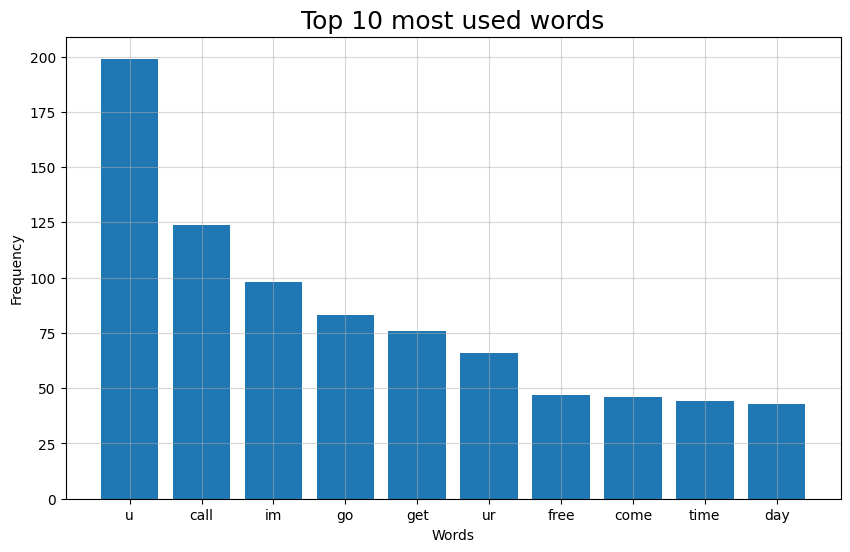

In [18]:
import collections
words = []
for text in df_train['text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

In [19]:
# Maximum number of words to be considered in the vocabulary
max_words = 10000 
# Maximum number of tokens in a sequence
max_len = 200 
# Tokenizer
tokenizer = Tokenizer(num_words = max_words) 
# Snap tokenizer to text data
tokenizer.fit_on_texts(df_train['text']) 
# Converts texts into strings of numbers
sequences_train = tokenizer.texts_to_sequences(df_train['text']) 
sequences_val = tokenizer.texts_to_sequences(df_test['text']) 
# Mapping words to indexes
word_index = tokenizer.word_index 

In [20]:
# Sequence padding
data_train = pad_sequences(sequences_train, maxlen = max_len)
data_val = pad_sequences(sequences_val, maxlen = max_len)

In [21]:
# Create the model
# Hidden Layer yang digunakan 1 yaitu GlobalAveragePooling1D
# GlobalAveragePooling1D digunakan untuk mengurangi dimensi dari data
model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Checking summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Fit model
history = model.fit(data_train, df_train['label'], epochs = 15, batch_size = 64, validation_data = (data_val, df_test['label']))

Epoch 1/15
15/15 [==============================] - 1s 14ms/step - loss: 0.6739 - accuracy: 0.8725 - val_loss: 0.6588 - val_accuracy: 0.8560
Epoch 2/15
15/15 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.8725 - val_loss: 0.6295 - val_accuracy: 0.8560
Epoch 3/15
15/15 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.8725 - val_loss: 0.6007 - val_accuracy: 0.8560
Epoch 4/15
15/15 [==============================] - 0s 4ms/step - loss: 0.5777 - accuracy: 0.8725 - val_loss: 0.5724 - val_accuracy: 0.8560
Epoch 5/15
15/15 [==============================] - 0s 4ms/step - loss: 0.5468 - accuracy: 0.8725 - val_loss: 0.5457 - val_accuracy: 0.8560
Epoch 6/15
15/15 [==============================] - 0s 4ms/step - loss: 0.5174 - accuracy: 0.8725 - val_loss: 0.5209 - val_accuracy: 0.8560
Epoch 7/15
15/15 [==============================] - 0s 4ms/step - loss: 0.4904 - accuracy: 0.8725 - val_loss: 0.4982 - val_accuracy: 0.8560
Epoch 8/15
15/15 [=

In [23]:
loss, accuracy = model.evaluate(data_val, df_test['label'], verbose = 0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 85.600001


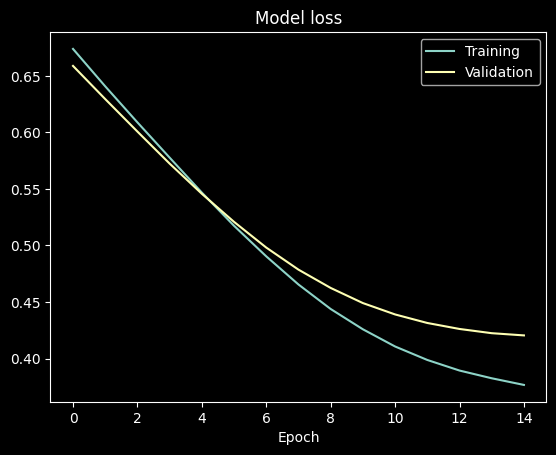

In [24]:
# Loss graph
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

In [25]:
from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(data_train, df_train['label'], epochs=15, validation_data=(data_val, df_test['label']), callbacks=[tensorboard_callback])

Epoch 1/15
30/30 [==============================] - 0s 12ms/step - loss: 0.3713 - accuracy: 0.8725 - val_loss: 0.4185 - val_accuracy: 0.8560
Epoch 2/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3668 - accuracy: 0.8725 - val_loss: 0.4184 - val_accuracy: 0.8560
Epoch 3/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.8725 - val_loss: 0.4191 - val_accuracy: 0.8560
Epoch 4/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.8725 - val_loss: 0.4199 - val_accuracy: 0.8560
Epoch 5/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3607 - accuracy: 0.8725 - val_loss: 0.4205 - val_accuracy: 0.8560
Epoch 6/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3594 - accuracy: 0.8725 - val_loss: 0.4213 - val_accuracy: 0.8560
Epoch 7/15
30/30 [==============================] - 0s 4ms/step - loss: 0.3582 - accuracy: 0.8725 - val_loss: 0.4218 - val_accuracy: 0.8560
Epoch 8/15
30/30 [=

In [26]:
%load_ext tensorboard

In [27]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 72756), started 0:40:30 ago. (Use '!kill 72756' to kill it.)

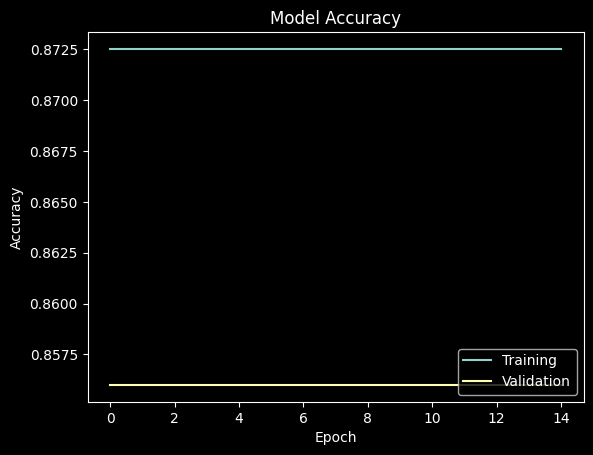

In [28]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()

In [29]:
# Model Saved
model.save('spam_email.h5')